<h1 align=center>大数据基础与实践课程项目 </h1>

<hr>
<div><h1 align=center><font style="font-style:italic;">IMDb电影评论情感分析</font></h1></div>
<div><h3 align=center>作者：<font style="font-style:italic;">蒋佐右 124120910084</font></h3></div>

### 1. 项目概述
本项目的任务是实现一个基于IMDb电影评论数据集的情感分析模型，使用LSTM（长短期记忆网络）来预测电影评论的情感倾向(postive/negative)。
数据集较大，助教老师批改作业时参考本notebook的输出结果，但是建议用demo子文件夹下的demo_20.ipynb来检查运行（数据集共80条，为完整数据集的0.16%）。

In [64]:
# # 安装库
# !conda install numpy=1.26.4 pandas=2.2.3 matplotlib=3.9.2 scikit-learn=1.5.1 seaborn=0.13.2 gensim=4.3.3 jieba=0.42.1 wordcloud=1.9.3 tqdm=4.66.5 -y
# !conda install pytorch=2.5.1 -c pytorch -y

In [65]:
conda list

# packages in environment at /root/miniconda3/envs/zuoyou:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
asttokens                 3.0.0              pyhd8ed1ab_1    conda-forge
bzip2                     1.0.8                h5eee18b_6    https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
ca-certificates           2024.11.26           h06a4308_0    https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
comm                      0.2.2              pyhd8ed1ab_1    conda-forge
contourpy                 1.3.1                    pypi_0    pypi
cycler                    0.12.1                   pypi_0    pypi
debugpy                   1.6.7           py312h6a678d5_0    https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
decorator                 5.1.1              pyhd8ed1ab_1    conda-forge
exceptiongroup          

In [66]:
!nvidia-smi

Wed Dec 11 01:38:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:00:0A.0 Off |                  Off |
| N/A   35C    P0             39W /  250W |    2841MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### 2. 数据集（选择现有数据集）
- **公开数据集论文**：https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf
- **公开数据集地址**：https://ai.stanford.edu/~amaas/data/sentiment

### 3. 数据预处理
- **数据集**：原始数据集文件夹分为test/train，每个数据集又分为postive/negative子集，每个子集包含12500条数据。（详见original data）
- **处理方式**：根据分类标签给数据加上0/1的情感标签，并合并到一个txt文件中。

In [ ]:
import os
import random

# 封装函数，读取指定目录下的所有文本文件，打上指定标签，并将结果保存为一个新的文本文件。
def process_and_label_reviews(input_dir, label, output_file):
    labeled_reviews = [] # 保存所有标记后的评论

    # 遍历输入目录中的所有文件
    for file_name in os.listdir(input_dir):
        file_path = os.path.join(input_dir, file_name) # 构建文件路径

        # 仅处理 .txt 文件
        if file_name.endswith(".txt"):
            try:
                with open(file_path, "r", encoding="utf-8") as file: 
                    content = file.read().strip()  # 去除多余空格和换行
                    if content:  # 如果文件非空
                        labeled_reviews.append(f"{label},{content}") # 添加标签和评论
            except Exception as e:
                print(f"Error reading file {file_name}: {e}") # 打印错误消息

    # 保存到输出文件
    with open(output_file, "w", encoding="utf-8") as output:
        for review in labeled_reviews:
            output.write(review + "\n")

    print(f"Processed {len(labeled_reviews)} reviews and saved to {output_file}.")
    return len(labeled_reviews)

In [69]:
processed_count = process_and_label_reviews("original data/train/train_neg", 0, "data/train_neg.txt")
processed_count = process_and_label_reviews("original data/train/train_pos", 1, "data/train_pos.txt")
processed_count = process_and_label_reviews("original data/test/test_neg", 0, "data/test_neg.txt")
processed_count = process_and_label_reviews("original data/test/test_pos", 1, "data/test_pos.txt")

Processed 12500 reviews and saved to data/train_neg.txt.
Processed 12500 reviews and saved to data/train_pos.txt.
Processed 12500 reviews and saved to data/test_neg.txt.
Processed 12500 reviews and saved to data/test_pos.txt.


In [ ]:
# 封装函数，将多个文件的数据合并、随机打乱，并保存到一个新的文件中。
def merge_files(input_files, output_file):
    combined_reviews = [] # 保存评论

    # 读取所有文件中的数据
    for file_path in input_files:
        try:
            with open(file_path, "r", encoding="utf-8") as file:
                combined_reviews.extend(file.readlines()) 
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

    # 随机打乱数据
    random.shuffle(combined_reviews)

    # 保存打乱后的数据到新文件
    with open(output_file, "w", encoding="utf-8") as output:
        output.writelines(combined_reviews)

    print(f"Shuffled and merged {len(combined_reviews)} reviews into {output_file}.")

In [71]:
merge_files(["data/test_neg.txt", "data/test_pos.txt"],"data/test.txt")
merge_files(["data/train_neg.txt", "data/train_pos.txt"],"data/train.txt")

Shuffled and merged 25000 reviews into data/test.txt.
Shuffled and merged 25000 reviews into data/train.txt.


### 4. 数据加载
- **数据集**：原始数据集文件夹分为test/train，每个数据集又分为postive/negative子集。（详见original data）
- **处理方式**：根据分类标签给数据加上0/1的情感标签，并合并到一个txt文件中。

In [ ]:
import jieba
import re
# 封装函数, 对文本进行处理
def processing(text):
    # 去除 HTML 标签
    text = re.sub(r"<.*?>", " ", text)                
    # 分词
    words = [w for w in jieba.lcut(text) if w.isalpha()]
    # 用空格拼接成字符串
    result = " ".join(words)
    return result

In [ ]:
def load_corpus(path):
    data = []
    with open(path, "r", encoding="utf8") as f:
        for line in f:
            # 按第一个逗号分割，避免内容中的逗号干扰
            line = line.strip()
            if line:  # 跳过空行
                label, content = line.split(",", 1) # 仅分割第一个逗号，避免内容中的逗号干扰 
                content = processing(content)
                data.append((content, int(label)))  # 标签是0或1，转换为整数
    return data

In [74]:
# 分别加载训练集和测试集
train_data = load_corpus("data/train.txt")
test_data = load_corpus("data/test.txt")

In [75]:
import pandas as pd

df_train = pd.DataFrame(train_data, columns=["text", "label"])
df_test = pd.DataFrame(test_data, columns=["text", "label"])
df_train.head()

,text,label
0,The idea is to have something interesting happ...,0
1,It s great to see Jorja Fox in a role where sh...,1
2,I am very disappointed with K The original goo...,0
3,This solid little horror film is actually one ...,0
4,This has got to be a unique twists of two genr...,1


### 5. 数据可视化分析

/tmp/ipykernel_29296/1704324030.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis")


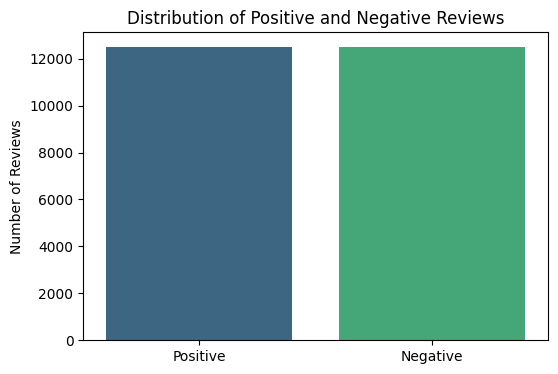

In [76]:
# 训练集样本分布情况
import matplotlib.pyplot as plt
import seaborn as sns

# 统计正负样本数量
positive_count = df_train[df_train['label'] == 1].shape[0]
negative_count = df_train[df_train['label'] == 0].shape[0]

# 绘制条状图
labels = ['Positive', 'Negative']
counts = [positive_count, negative_count]

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=counts, palette="viridis")
plt.title('Distribution of Positive and Negative Reviews')
plt.ylabel('Number of Reviews')
plt.show()

/tmp/ipykernel_29296/789659033.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_length', data=df_train, palette="Set2")


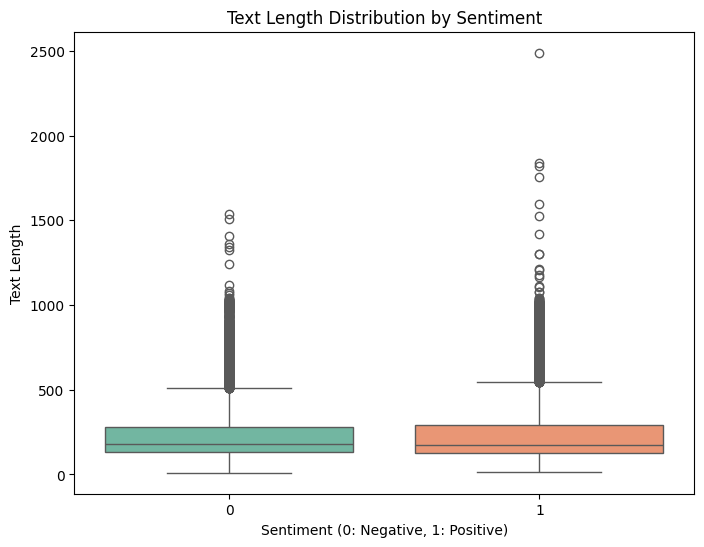

In [77]:
##不同情感类别的文本长度分布

# 计算文本长度
df_train['text_length'] = df_train['text'].apply(lambda x: len(x.split()))

# 绘制箱线图
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='text_length', data=df_train, palette="Set2")
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Text Length')
plt.show()

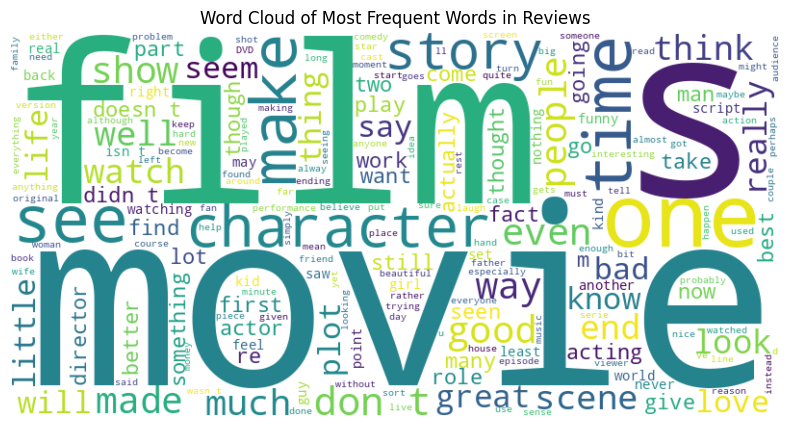

In [78]:
# 训练集词云
from wordcloud import WordCloud

# 合并所有文本
all_text = " ".join(df_train['text'].tolist())

# 生成词云
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words in Reviews')
plt.show()

### 6. 训练词向量

In [79]:
# word2vec要求的输入格式: list(word)
wv_input = df_train['text'].map(lambda s: s.split(" "))# 将训练集中的文本转换为 word2vec 模型的输入格式
wv_input.head()       

0    [The, idea, is, to, have, something, interesti...
1    [It, s, great, to, see, Jorja, Fox, in, a, rol...
2    [I, am, very, disappointed, with, K, The, orig...
3    [This, solid, little, horror, film, is, actual...
4    [This, has, got, to, be, a, unique, twists, of...
Name: text, dtype: object

In [ ]:
from gensim import models
from tqdm.auto import tqdm

# Word2Vec，其余参数量均为默认值
word2vec = models.Word2Vec(
    vector_size=64,   # 词向量维度
    min_count=1,      # 最小词频，考虑所有词
    epochs=200       # 迭代轮次
)

# 构建词汇表
word2vec.build_vocab(wv_input)

# 训练 Word2Vec 模型，并使用 tqdm 显示进度条
with tqdm(total=word2vec.epochs, desc="Training Word2Vec") as pbar:
    for epoch in range(word2vec.epochs):
        word2vec.train(
            wv_input, # 训练集
            total_examples=word2vec.corpus_count, # 训练集大小
            epochs=1 # 每次迭代一次
        )
        pbar.update(1)  # 更新进度条
        pbar.set_postfix({"Epoch": epoch + 1})  # 显示当前 epoch

Training Word2Vec: 100%|██████████| 200/200 [10:05<00:00,  3.03s/it, Epoch=200]


查找近义词, 直观感受训练得到的word2vec效果

In [81]:
word2vec.wv.most_similar("You")

[('We', 0.7779507040977478),
 ('you', 0.7645905613899231),
 ('we', 0.7340291142463684),
 ('I', 0.6767842769622803),
 ('They', 0.6438711285591125),
 ('u', 0.601439893245697),
 ('i', 0.577172577381134),
 ('they', 0.54689621925354),
 ('answears', 0.522258996963501),
 ('Ya', 0.5219678282737732)]

In [82]:
word2vec.wv.most_similar("good")

[('decent', 0.8260085582733154),
 ('great', 0.8083224296569824),
 ('bad', 0.7919091582298279),
 ('nice', 0.7345735430717468),
 ('fine', 0.7181881666183472),
 ('cool', 0.7166962623596191),
 ('solid', 0.6930065155029297),
 ('perfect', 0.677984356880188),
 ('fantastic', 0.6656774282455444),
 ('terrific', 0.664729654788971)]

In [83]:
word2vec.wv.most_similar("excellent")

[('outstanding', 0.923140823841095),
 ('amazing', 0.7890225648880005),
 ('incredible', 0.7832885980606079),
 ('terrific', 0.7655730843544006),
 ('exceptional', 0.763860285282135),
 ('impressive', 0.7442188858985901),
 ('superb', 0.7362487316131592),
 ('awesome', 0.7156968116760254),
 ('fantastic', 0.7110673785209656),
 ('impeccable', 0.7108775973320007)]

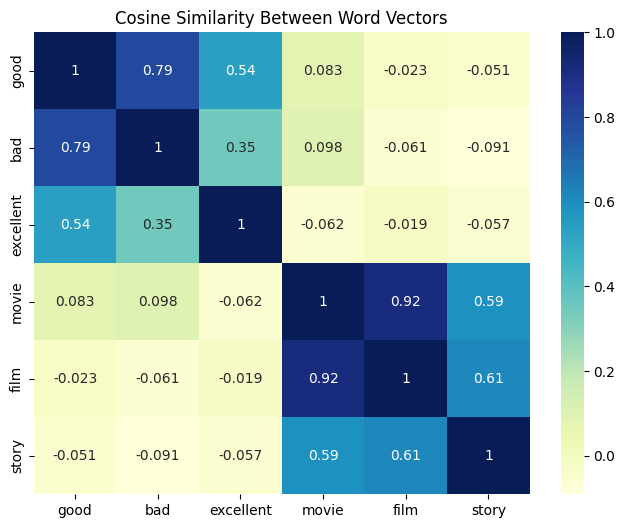

In [84]:
# 词向量的相似度
import numpy as np

# 选择一些常见的词
words = ['good', 'bad', 'excellent', 'movie', 'film', 'story']

# 获取这些词的词向量
word_vectors = np.array([word2vec.wv[word] for word in words])

# 计算词向量之间的余弦相似度
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(word_vectors)

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, xticklabels=words, yticklabels=words, cmap="YlGnBu")
plt.title('Cosine Similarity Between Word Vectors')
plt.show()

### 7. LSTM

In [85]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence,pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

#如果有GPU就用GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
# 超参数
learning_rate = 5e-4 # 学习率
input_size = 768 # 输入大小
num_epoches = 100 # 迭代次数
batch_size = 100 # 批大小
embed_size = 64 # 词向量维度
hidden_size = 64 # 隐藏层大小
num_layers = 2 # LSTM 层数

In [ ]:
# 定义数据集
class MyDataset(Dataset):
    def __init__(self, df):
        self.data = [] # 保存词向量
        self.label = df["label"].tolist() # 保存标签
        for s in df["text"].tolist(): # 遍历所有评论
            vectors = [] # 保存词向量
            for w in s.split(" "): # 遍历评论中的每个词
                if w in word2vec.wv.key_to_index: # 如果词在词汇表中，将每个词替换为对应的词向量
                    vectors.append(word2vec.wv[w])   
            vectors = torch.Tensor(vectors) # 转换为张量
            self.data.append(vectors) # 添加到数据集中
    
    # 获取数据
    def __getitem__(self, index):
        data = self.data[index] 
        label = self.label[index]
        return data, label
    
    # 获取数据集大小
    def __len__(self):
        return len(self.label)

In [ ]:
def collate_fn(data):
    """
    :param data: 第0维：data，第1维：label
    :return: 序列化的data、记录实际长度的序列、以及label列表
    """
    data.sort(key=lambda x: len(x[0]), reverse=True) # pack_padded_sequence要求要按照序列的长度倒序排列
    data_length = [len(sq[0]) for sq in data] # 记录每个序列的实际长度
    x = [i[0] for i in data] # 获取所有的data
    y = [i[1] for i in data] # 获取所有的label
    data = pad_sequence(x, batch_first=True, padding_value=0)   # 用RNN处理变长序列的必要操作
    return data, torch.tensor(y, dtype=torch.float32), data_length # 返回序列化的data、记录实际长度的序列、以及label列表

In [91]:
# 训练集
train_data = MyDataset(df_train)
train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

# 测试集
test_data = MyDataset(df_test)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [ ]:
# 网络结构
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__() 
        self.hidden_size = hidden_size # 隐藏层大小
        self.num_layers = num_layers # LSTM 层数
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True) # 双向LSTM
        self.fc = nn.Linear(hidden_size * 2, 1)  # 双向, 输出维度要*2
        self.sigmoid = nn.Sigmoid() # 激活函数

    def forward(self, x, lengths):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)  # 双向, 第一个维度要*2
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) # 第一个维度*2
        
        packed_input = torch.nn.utils.rnn.pack_padded_sequence(input=x, lengths=lengths, batch_first=True) 
        packed_out, (h_n, h_c) = self.lstm(packed_input, (h0, c0))

        lstm_out = torch.cat([h_n[-2], h_n[-1]], 1)  # 双向, 所以要将最后两维拼接, 得到的就是最后一个time step的输出
        out = self.fc(lstm_out) # 全连接层
        out = self.sigmoid(out) # 激活函数
        return out

lstm = LSTM(embed_size, hidden_size, num_layers)

In [98]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score,f1_score

# 在测试集效果检验
def test():
    y_pred, y_true = [], []

    with torch.no_grad():
        for x, labels, lengths in test_loader:
            x = x.to(device)
            outputs = lstm(x, lengths)          # 前向传播
            outputs = outputs.view(-1)          # 将输出展平
            y_pred.append(outputs)
            y_true.append(labels)

    y_prob = torch.cat(y_pred).cpu()  # 将 Tensor 移动到 CPU
    y_true = torch.cat(y_true).cpu()  # 将 Tensor 移动到 CPU
    y_pred = y_prob.clone()
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    
    # 计算 Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # 打印分类报告
    print(metrics.classification_report(y_true, y_pred))
    print("准确率:", metrics.accuracy_score(y_true, y_pred))
    print("AUC:", metrics.roc_auc_score(y_true, y_prob))
    
    # 返回 Precision, Recall, F1-Score
    return precision, recall, f1

In [99]:
# 定义损失函数和优化器
criterion = nn.BCELoss() # 二分类交叉熵
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # Adam 优化器

In [100]:
# 训练过程中的记录
loss_history = []
precision_history = []
recall_history = []
f1_history = []

# 将模型移动到GPU
lstm.to(device)

# 迭代训练
for epoch in range(num_epoches):
    total_loss = 0  # 每个epoch的总损失
    
    # 为每个 epoch 添加进度条
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epoches}") as pbar:
        for i, (x, labels, lengths) in enumerate(train_loader):
            x = x.to(device)
            labels = labels.to(device)
            outputs = lstm(x, lengths)          # 前向传播
            logits = outputs.view(-1)           # 将输出展平
            loss = criterion(logits, labels)    # loss计算
            total_loss += loss.item()           # 累加损失
            optimizer.zero_grad()               # 梯度清零
            loss.backward(retain_graph=True)    # 反向传播，计算梯度
            optimizer.step()                    # 梯度更新

            # 更新进度条
            pbar.update(1)
            pbar.set_postfix({"Loss": loss.item()})  # 显示当前 batch 的损失
    
    # 每个epoch结束时输出该epoch的Avg-Loss
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Training Finished. Average Loss: {avg_loss:.4f}")
    loss_history.append(avg_loss)  # 记录每个epoch的平均损失

    # 测试
    print(f"Epoch {epoch+1} Test Results:")
    precision, recall, f1 = test()
    
    # 记录Precision、Recall、F1-Score
    precision_history.append(precision)
    recall_history.append(recall)
    f1_history.append(f1)

Epoch 1/100: 100%|██████████| 250/250 [00:30<00:00,  8.20it/s, Loss=0.321]


Epoch 1 Training Finished. Average Loss: 0.4045
Epoch 1 Test Results:
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84     12500
         1.0       0.83      0.86      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000

准确率: 0.84476
AUC: 0.9157750784


Epoch 2/100: 100%|██████████| 250/250 [00:29<00:00,  8.59it/s, Loss=0.49] 


Epoch 2 Training Finished. Average Loss: 0.4295
Epoch 2 Test Results:
              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84     12500
         1.0       0.83      0.86      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

准确率: 0.84192
AUC: 0.9162690367999999


Epoch 3/100: 100%|██████████| 250/250 [00:26<00:00,  9.30it/s, Loss=0.449]


Epoch 3 Training Finished. Average Loss: 0.3556
Epoch 3 Test Results:
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85     12500
         1.0       0.84      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

准确率: 0.84816
AUC: 0.9208974048


Epoch 4/100: 100%|██████████| 250/250 [00:27<00:00,  9.13it/s, Loss=0.416]


Epoch 4 Training Finished. Average Loss: 0.3414
Epoch 4 Test Results:
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86     12500
         1.0       0.87      0.83      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

准确率: 0.85268
AUC: 0.9210632160000001


Epoch 5/100: 100%|██████████| 250/250 [00:29<00:00,  8.45it/s, Loss=0.455]


Epoch 5 Training Finished. Average Loss: 0.4132
Epoch 5 Test Results:
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84     12500
         1.0       0.85      0.81      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

准确率: 0.83544
AUC: 0.9121659263999999


Epoch 6/100: 100%|██████████| 250/250 [00:26<00:00,  9.30it/s, Loss=0.363]


Epoch 6 Training Finished. Average Loss: 0.3230
Epoch 6 Test Results:
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87     12500
         1.0       0.91      0.79      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

准确率: 0.85708
AUC: 0.9399625824000001


Epoch 7/100: 100%|██████████| 250/250 [00:26<00:00,  9.32it/s, Loss=0.264]


Epoch 7 Training Finished. Average Loss: 0.3402
Epoch 7 Test Results:
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86     12500
         1.0       0.85      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

准确率: 0.85956
AUC: 0.9321797504


Epoch 8/100: 100%|██████████| 250/250 [00:37<00:00,  6.71it/s, Loss=0.315]


Epoch 8 Training Finished. Average Loss: 0.3181
Epoch 8 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87     12500
         1.0       0.86      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

准确率: 0.87508
AUC: 0.944570432


Epoch 9/100: 100%|██████████| 250/250 [00:29<00:00,  8.47it/s, Loss=0.223]


Epoch 9 Training Finished. Average Loss: 0.2987
Epoch 9 Test Results:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87     12500
         1.0       0.89      0.84      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

准确率: 0.86916
AUC: 0.943456096


Epoch 10/100: 100%|██████████| 250/250 [00:26<00:00,  9.37it/s, Loss=0.394]


Epoch 10 Training Finished. Average Loss: 0.3166
Epoch 10 Test Results:
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88     12500
         1.0       0.90      0.84      0.87     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

准确率: 0.87692
AUC: 0.9482861280000001


Epoch 11/100: 100%|██████████| 250/250 [00:26<00:00,  9.44it/s, Loss=0.252]


Epoch 11 Training Finished. Average Loss: 0.3441
Epoch 11 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88     12500
         1.0       0.86      0.90      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

准确率: 0.87908
AUC: 0.9427159359999999


Epoch 12/100: 100%|██████████| 250/250 [00:26<00:00,  9.41it/s, Loss=0.246]


Epoch 12 Training Finished. Average Loss: 0.3054
Epoch 12 Test Results:
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87     12500
         1.0       0.89      0.84      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

准确率: 0.86824
AUC: 0.9375282144


Epoch 13/100: 100%|██████████| 250/250 [00:26<00:00,  9.39it/s, Loss=0.25] 


Epoch 13 Training Finished. Average Loss: 0.2723
Epoch 13 Test Results:
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89     12500
         1.0       0.89      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

准确率: 0.88464
AUC: 0.9528240544


Epoch 14/100: 100%|██████████| 250/250 [00:27<00:00,  8.96it/s, Loss=0.269]


Epoch 14 Training Finished. Average Loss: 0.2652
Epoch 14 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89108
AUC: 0.9550141248


Epoch 15/100: 100%|██████████| 250/250 [00:26<00:00,  9.46it/s, Loss=0.252]


Epoch 15 Training Finished. Average Loss: 0.2464
Epoch 15 Test Results:
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90     12500
         1.0       0.92      0.87      0.89     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.89     25000
weighted avg       0.90      0.90      0.89     25000

准确率: 0.895
AUC: 0.9605793183999999


Epoch 16/100: 100%|██████████| 250/250 [00:26<00:00,  9.35it/s, Loss=0.19] 


Epoch 16 Training Finished. Average Loss: 0.2290
Epoch 16 Test Results:
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89     12500
         1.0       0.88      0.92      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89712
AUC: 0.962521152


Epoch 17/100: 100%|██████████| 250/250 [00:35<00:00,  7.13it/s, Loss=0.15]  


Epoch 17 Training Finished. Average Loss: 0.2184
Epoch 17 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     12500
         1.0       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89932
AUC: 0.9639232160000002


Epoch 18/100: 100%|██████████| 250/250 [00:27<00:00,  9.13it/s, Loss=0.256] 


Epoch 18 Training Finished. Average Loss: 0.2072
Epoch 18 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     12500
         1.0       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.90208
AUC: 0.9653695776000001


Epoch 19/100: 100%|██████████| 250/250 [00:26<00:00,  9.31it/s, Loss=0.115] 


Epoch 19 Training Finished. Average Loss: 0.1977
Epoch 19 Test Results:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     12500
         1.0       0.93      0.86      0.89     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.8972
AUC: 0.9650151136


Epoch 20/100: 100%|██████████| 250/250 [00:26<00:00,  9.35it/s, Loss=0.126] 


Epoch 20 Training Finished. Average Loss: 0.1873
Epoch 20 Test Results:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     12500
         1.0       0.93      0.86      0.89     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.8978
AUC: 0.9663360992000001


Epoch 21/100: 100%|██████████| 250/250 [00:26<00:00,  9.38it/s, Loss=0.214] 


Epoch 21 Training Finished. Average Loss: 0.1755
Epoch 21 Test Results:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90     12500
         1.0       0.90      0.91      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000

准确率: 0.90544
AUC: 0.966179408


Epoch 22/100: 100%|██████████| 250/250 [00:26<00:00,  9.33it/s, Loss=0.191] 


Epoch 22 Training Finished. Average Loss: 0.1642
Epoch 22 Test Results:
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.91     12500
         1.0       0.89      0.92      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000

准确率: 0.90656
AUC: 0.9665054687999999


Epoch 23/100: 100%|██████████| 250/250 [00:27<00:00,  9.24it/s, Loss=0.214] 


Epoch 23 Training Finished. Average Loss: 0.1527
Epoch 23 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91     12500
         1.0       0.92      0.89      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.90396
AUC: 0.9661386976000002


Epoch 24/100: 100%|██████████| 250/250 [00:26<00:00,  9.40it/s, Loss=0.0798]


Epoch 24 Training Finished. Average Loss: 0.1362
Epoch 24 Test Results:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91     12500
         1.0       0.90      0.92      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000

准确率: 0.90644
AUC: 0.965698912


Epoch 25/100: 100%|██████████| 250/250 [00:26<00:00,  9.32it/s, Loss=0.0482]


Epoch 25 Training Finished. Average Loss: 0.1257
Epoch 25 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90     12500
         1.0       0.91      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.90364
AUC: 0.9643286976000001


Epoch 26/100: 100%|██████████| 250/250 [00:26<00:00,  9.40it/s, Loss=0.185] 


Epoch 26 Training Finished. Average Loss: 0.1095
Epoch 26 Test Results:
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     12500
         1.0       0.92      0.87      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89888
AUC: 0.9629832768000001


Epoch 27/100: 100%|██████████| 250/250 [00:26<00:00,  9.39it/s, Loss=0.0303]


Epoch 27 Training Finished. Average Loss: 0.0927
Epoch 27 Test Results:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     12500
         1.0       0.93      0.85      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.90      0.89      0.89     25000
weighted avg       0.90      0.89      0.89     25000

准确率: 0.89396
AUC: 0.9613799264


Epoch 28/100: 100%|██████████| 250/250 [00:26<00:00,  9.49it/s, Loss=0.165] 


Epoch 28 Training Finished. Average Loss: 0.0836
Epoch 28 Test Results:
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88     12500
         1.0       0.85      0.95      0.90     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.88944
AUC: 0.9600562816


Epoch 29/100: 100%|██████████| 250/250 [00:26<00:00,  9.36it/s, Loss=0.0624]


Epoch 29 Training Finished. Average Loss: 0.0645
Epoch 29 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     12500
         1.0       0.91      0.89      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.90236
AUC: 0.9593847776


Epoch 30/100: 100%|██████████| 250/250 [00:26<00:00,  9.52it/s, Loss=0.0504]


Epoch 30 Training Finished. Average Loss: 0.0614
Epoch 30 Test Results:
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90     12500
         1.0       0.92      0.86      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.90      0.89      0.89     25000
weighted avg       0.90      0.89      0.89     25000

准确率: 0.89308
AUC: 0.9581952224


Epoch 31/100: 100%|██████████| 250/250 [00:27<00:00,  9.22it/s, Loss=0.049]  


Epoch 31 Training Finished. Average Loss: 0.0507
Epoch 31 Test Results:
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89     12500
         1.0       0.88      0.92      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.897
AUC: 0.9568959456


Epoch 32/100: 100%|██████████| 250/250 [00:26<00:00,  9.37it/s, Loss=0.021]  


Epoch 32 Training Finished. Average Loss: 0.0467
Epoch 32 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     12500
         1.0       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.8986
AUC: 0.9550479519999999


Epoch 33/100: 100%|██████████| 250/250 [00:26<00:00,  9.29it/s, Loss=0.0123] 


Epoch 33 Training Finished. Average Loss: 0.0406
Epoch 33 Test Results:
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     12500
         1.0       0.89      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89812
AUC: 0.9548727936


Epoch 34/100: 100%|██████████| 250/250 [00:26<00:00,  9.39it/s, Loss=0.0293] 


Epoch 34 Training Finished. Average Loss: 0.0329
Epoch 34 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89636
AUC: 0.9523342719999999


Epoch 35/100: 100%|██████████| 250/250 [00:26<00:00,  9.50it/s, Loss=0.0705] 


Epoch 35 Training Finished. Average Loss: 0.0343
Epoch 35 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89852
AUC: 0.9532839296000001


Epoch 36/100: 100%|██████████| 250/250 [00:26<00:00,  9.35it/s, Loss=0.0107] 


Epoch 36 Training Finished. Average Loss: 0.0308
Epoch 36 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89692
AUC: 0.9519570368000001


Epoch 37/100: 100%|██████████| 250/250 [00:27<00:00,  9.18it/s, Loss=0.0199] 


Epoch 37 Training Finished. Average Loss: 0.0341
Epoch 37 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90     12500
         1.0       0.90      0.89      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.8982
AUC: 0.95163344


Epoch 38/100: 100%|██████████| 250/250 [00:26<00:00,  9.31it/s, Loss=0.0612] 


Epoch 38 Training Finished. Average Loss: 0.0337
Epoch 38 Test Results:
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89     12500
         1.0       0.87      0.92      0.90     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89344
AUC: 0.9521259968


Epoch 39/100: 100%|██████████| 250/250 [00:26<00:00,  9.30it/s, Loss=0.0225] 


Epoch 39 Training Finished. Average Loss: 0.0247
Epoch 39 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89796
AUC: 0.9522166336


Epoch 40/100: 100%|██████████| 250/250 [00:26<00:00,  9.33it/s, Loss=0.00483]


Epoch 40 Training Finished. Average Loss: 0.0154
Epoch 40 Test Results:
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90     12500
         1.0       0.89      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.897
AUC: 0.9503111903999999


Epoch 41/100: 100%|██████████| 250/250 [00:26<00:00,  9.38it/s, Loss=0.00638]


Epoch 41 Training Finished. Average Loss: 0.0243
Epoch 41 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89424
AUC: 0.9492666111999999


Epoch 42/100: 100%|██████████| 250/250 [00:26<00:00,  9.42it/s, Loss=0.0836] 


Epoch 42 Training Finished. Average Loss: 0.0227
Epoch 42 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     12500
         1.0       0.90      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89328
AUC: 0.9515655903999999


Epoch 43/100: 100%|██████████| 250/250 [00:27<00:00,  9.18it/s, Loss=0.018]  


Epoch 43 Training Finished. Average Loss: 0.0203
Epoch 43 Test Results:
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89     12500
         1.0       0.93      0.83      0.88     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.88     25000
weighted avg       0.89      0.89      0.88     25000

准确率: 0.88516
AUC: 0.9492343520000001


Epoch 44/100: 100%|██████████| 250/250 [00:26<00:00,  9.43it/s, Loss=0.0029] 


Epoch 44 Training Finished. Average Loss: 0.0140
Epoch 44 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     12500
         1.0       0.90      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89452
AUC: 0.9499489216


Epoch 45/100: 100%|██████████| 250/250 [00:26<00:00,  9.27it/s, Loss=0.00484]


Epoch 45 Training Finished. Average Loss: 0.0123
Epoch 45 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     12500
         1.0       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89596
AUC: 0.9492182175999999


Epoch 46/100: 100%|██████████| 250/250 [00:26<00:00,  9.33it/s, Loss=0.0023]  


Epoch 46 Training Finished. Average Loss: 0.0138
Epoch 46 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.8934
AUC: 0.9492051584


Epoch 47/100: 100%|██████████| 250/250 [00:26<00:00,  9.27it/s, Loss=0.00966]


Epoch 47 Training Finished. Average Loss: 0.0246
Epoch 47 Test Results:
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89     12500
         1.0       0.92      0.86      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89052
AUC: 0.9477771743999999


Epoch 48/100: 100%|██████████| 250/250 [00:26<00:00,  9.41it/s, Loss=0.0079] 


Epoch 48 Training Finished. Average Loss: 0.0153
Epoch 48 Test Results:
              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88     12500
         1.0       0.86      0.93      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.8882
AUC: 0.9442115744000001


Epoch 49/100: 100%|██████████| 250/250 [00:26<00:00,  9.43it/s, Loss=0.00151] 


Epoch 49 Training Finished. Average Loss: 0.0107
Epoch 49 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90     12500
         1.0       0.90      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.8948
AUC: 0.9491790368


Epoch 50/100: 100%|██████████| 250/250 [00:26<00:00,  9.45it/s, Loss=0.0441]  


Epoch 50 Training Finished. Average Loss: 0.0111
Epoch 50 Test Results:
              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87     12500
         1.0       0.84      0.94      0.89     12500

    accuracy                           0.88     25000
   macro avg       0.89      0.88      0.88     25000
weighted avg       0.89      0.88      0.88     25000

准确率: 0.87988
AUC: 0.9404140096


Epoch 51/100: 100%|██████████| 250/250 [00:26<00:00,  9.43it/s, Loss=0.00329] 


Epoch 51 Training Finished. Average Loss: 0.0189
Epoch 51 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.8972
AUC: 0.9488658527999999


Epoch 52/100: 100%|██████████| 250/250 [00:26<00:00,  9.34it/s, Loss=0.00254] 


Epoch 52 Training Finished. Average Loss: 0.0074
Epoch 52 Test Results:
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89     12500
         1.0       0.92      0.86      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.88952
AUC: 0.9472821280000001


Epoch 53/100: 100%|██████████| 250/250 [00:26<00:00,  9.42it/s, Loss=0.00143] 


Epoch 53 Training Finished. Average Loss: 0.0067
Epoch 53 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     12500
         1.0       0.90      0.89      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89628
AUC: 0.9476167936


Epoch 54/100: 100%|██████████| 250/250 [00:26<00:00,  9.27it/s, Loss=0.00175] 


Epoch 54 Training Finished. Average Loss: 0.0083
Epoch 54 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90     12500
         1.0       0.90      0.88      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89448
AUC: 0.9495796736000001


Epoch 55/100: 100%|██████████| 250/250 [00:26<00:00,  9.32it/s, Loss=0.0103]  


Epoch 55 Training Finished. Average Loss: 0.0082
Epoch 55 Test Results:
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89     12500
         1.0       0.88      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89524
AUC: 0.948201504


Epoch 56/100: 100%|██████████| 250/250 [00:26<00:00,  9.42it/s, Loss=0.0138]  


Epoch 56 Training Finished. Average Loss: 0.0172
Epoch 56 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     12500
         1.0       0.90      0.89      0.89     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89564
AUC: 0.9471908224


Epoch 57/100: 100%|██████████| 250/250 [00:26<00:00,  9.33it/s, Loss=0.00134] 


Epoch 57 Training Finished. Average Loss: 0.0036
Epoch 57 Test Results:
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90     12500
         1.0       0.91      0.88      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89436
AUC: 0.9489848544


Epoch 58/100: 100%|██████████| 250/250 [00:26<00:00,  9.45it/s, Loss=0.00045] 


Epoch 58 Training Finished. Average Loss: 0.0019
Epoch 58 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     12500
         1.0       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89876
AUC: 0.9495509216


Epoch 59/100: 100%|██████████| 250/250 [00:27<00:00,  9.24it/s, Loss=0.000452]


Epoch 59 Training Finished. Average Loss: 0.0013
Epoch 59 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89832
AUC: 0.9481613151999999


Epoch 60/100: 100%|██████████| 250/250 [00:26<00:00,  9.47it/s, Loss=0.000162]


Epoch 60 Training Finished. Average Loss: 0.0009
Epoch 60 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90     12500
         1.0       0.90      0.89      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89784
AUC: 0.9485820096


Epoch 61/100: 100%|██████████| 250/250 [00:26<00:00,  9.36it/s, Loss=0.000638]


Epoch 61 Training Finished. Average Loss: 0.0007
Epoch 61 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     12500
         1.0       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89776
AUC: 0.9476767136000002


Epoch 62/100: 100%|██████████| 250/250 [00:26<00:00,  9.46it/s, Loss=0.000325]


Epoch 62 Training Finished. Average Loss: 0.0005
Epoch 62 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.8978
AUC: 0.9476908224000001


Epoch 63/100: 100%|██████████| 250/250 [00:26<00:00,  9.45it/s, Loss=0.000254]


Epoch 63 Training Finished. Average Loss: 0.0004
Epoch 63 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     12500
         1.0       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89768
AUC: 0.9477081984


Epoch 64/100: 100%|██████████| 250/250 [00:26<00:00,  9.31it/s, Loss=0.000128]


Epoch 64 Training Finished. Average Loss: 0.0003
Epoch 64 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     12500
         1.0       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89704
AUC: 0.9475709536000001


Epoch 65/100: 100%|██████████| 250/250 [00:26<00:00,  9.34it/s, Loss=0.000257]


Epoch 65 Training Finished. Average Loss: 0.0002
Epoch 65 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89704
AUC: 0.9474555168000001


Epoch 66/100: 100%|██████████| 250/250 [00:26<00:00,  9.33it/s, Loss=0.000164]


Epoch 66 Training Finished. Average Loss: 0.0002
Epoch 66 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.8972
AUC: 0.9477702975999999


Epoch 67/100: 100%|██████████| 250/250 [00:26<00:00,  9.28it/s, Loss=0.000192]


Epoch 67 Training Finished. Average Loss: 0.0002
Epoch 67 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     12500
         1.0       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89704
AUC: 0.9475288544000001


Epoch 68/100: 100%|██████████| 250/250 [00:26<00:00,  9.27it/s, Loss=6.83e-5] 


Epoch 68 Training Finished. Average Loss: 0.0001
Epoch 68 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89632
AUC: 0.9477736512


Epoch 69/100: 100%|██████████| 250/250 [00:26<00:00,  9.61it/s, Loss=0.000139]


Epoch 69 Training Finished. Average Loss: 0.0001
Epoch 69 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89592
AUC: 0.9476747967999999


Epoch 70/100: 100%|██████████| 250/250 [00:26<00:00,  9.31it/s, Loss=0.000133]


Epoch 70 Training Finished. Average Loss: 0.0001
Epoch 70 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89568
AUC: 0.9476891583999999


Epoch 71/100: 100%|██████████| 250/250 [00:26<00:00,  9.45it/s, Loss=3.42e-5] 


Epoch 71 Training Finished. Average Loss: 0.0001
Epoch 71 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89544
AUC: 0.9475307488000001


Epoch 72/100: 100%|██████████| 250/250 [00:26<00:00,  9.26it/s, Loss=3.62e-5] 


Epoch 72 Training Finished. Average Loss: 0.0001
Epoch 72 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89524
AUC: 0.9476818848


Epoch 73/100: 100%|██████████| 250/250 [00:26<00:00,  9.44it/s, Loss=2.42e-5] 


Epoch 73 Training Finished. Average Loss: 0.0001
Epoch 73 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89508
AUC: 0.9476380704


Epoch 74/100: 100%|██████████| 250/250 [00:26<00:00,  9.43it/s, Loss=3.56e-5] 


Epoch 74 Training Finished. Average Loss: 0.0000
Epoch 74 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12500
         1.0       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89528
AUC: 0.9474715456


Epoch 75/100: 100%|██████████| 250/250 [00:26<00:00,  9.38it/s, Loss=2.85e-5] 


Epoch 75 Training Finished. Average Loss: 0.0000
Epoch 75 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89444
AUC: 0.94770784


Epoch 76/100: 100%|██████████| 250/250 [00:26<00:00,  9.31it/s, Loss=1.62e-5]


Epoch 76 Training Finished. Average Loss: 0.0000
Epoch 76 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89448
AUC: 0.9475572287999998


Epoch 77/100: 100%|██████████| 250/250 [00:26<00:00,  9.39it/s, Loss=1.66e-5] 


Epoch 77 Training Finished. Average Loss: 0.0000
Epoch 77 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89416
AUC: 0.9475318176


Epoch 78/100: 100%|██████████| 250/250 [00:27<00:00,  9.20it/s, Loss=1.36e-5] 


Epoch 78 Training Finished. Average Loss: 0.0000
Epoch 78 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89384
AUC: 0.9475610048


Epoch 79/100: 100%|██████████| 250/250 [00:26<00:00,  9.50it/s, Loss=1.44e-5] 


Epoch 79 Training Finished. Average Loss: 0.0000
Epoch 79 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89372
AUC: 0.9476349984


Epoch 80/100: 100%|██████████| 250/250 [00:26<00:00,  9.33it/s, Loss=1.09e-5] 


Epoch 80 Training Finished. Average Loss: 0.0000
Epoch 80 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89368
AUC: 0.9476798879999999


Epoch 81/100: 100%|██████████| 250/250 [00:26<00:00,  9.27it/s, Loss=1.05e-5] 


Epoch 81 Training Finished. Average Loss: 0.0000
Epoch 81 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89352
AUC: 0.9476331616


Epoch 82/100: 100%|██████████| 250/250 [00:27<00:00,  9.19it/s, Loss=1.01e-5] 


Epoch 82 Training Finished. Average Loss: 0.0000
Epoch 82 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89352
AUC: 0.9475666176


Epoch 83/100: 100%|██████████| 250/250 [00:27<00:00,  9.25it/s, Loss=6.03e-6] 


Epoch 83 Training Finished. Average Loss: 0.0000
Epoch 83 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89336
AUC: 0.947476512


Epoch 84/100: 100%|██████████| 250/250 [00:26<00:00,  9.41it/s, Loss=9.95e-6] 


Epoch 84 Training Finished. Average Loss: 0.0000
Epoch 84 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89292
AUC: 0.9475752352000001


Epoch 85/100: 100%|██████████| 250/250 [00:27<00:00,  9.17it/s, Loss=4.68e-6]


Epoch 85 Training Finished. Average Loss: 0.0000
Epoch 85 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89332
AUC: 0.9475597536


Epoch 86/100: 100%|██████████| 250/250 [00:26<00:00,  9.32it/s, Loss=1e-5]   


Epoch 86 Training Finished. Average Loss: 0.0000
Epoch 86 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89332
AUC: 0.9477428800000001


Epoch 87/100: 100%|██████████| 250/250 [00:27<00:00,  9.25it/s, Loss=4.3e-6] 


Epoch 87 Training Finished. Average Loss: 0.0000
Epoch 87 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89292
AUC: 0.9475448287999999


Epoch 88/100: 100%|██████████| 250/250 [00:26<00:00,  9.41it/s, Loss=6.5e-6] 


Epoch 88 Training Finished. Average Loss: 0.0000
Epoch 88 Test Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89332
AUC: 0.9476263103999998


Epoch 89/100: 100%|██████████| 250/250 [00:26<00:00,  9.40it/s, Loss=3.5e-6] 


Epoch 89 Training Finished. Average Loss: 0.0000
Epoch 89 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.8928
AUC: 0.9475017215999999


Epoch 90/100: 100%|██████████| 250/250 [00:26<00:00,  9.28it/s, Loss=2.25e-6]


Epoch 90 Training Finished. Average Loss: 0.0000
Epoch 90 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89316
AUC: 0.9475488832000001


Epoch 91/100: 100%|██████████| 250/250 [00:26<00:00,  9.28it/s, Loss=1.78e-6]


Epoch 91 Training Finished. Average Loss: 0.0000
Epoch 91 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89272
AUC: 0.9476338624


Epoch 92/100: 100%|██████████| 250/250 [00:27<00:00,  8.95it/s, Loss=4.59e-6]


Epoch 92 Training Finished. Average Loss: 0.0000
Epoch 92 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89268
AUC: 0.9476016096


Epoch 93/100: 100%|██████████| 250/250 [00:26<00:00,  9.26it/s, Loss=1.2e-6] 


Epoch 93 Training Finished. Average Loss: 0.0000
Epoch 93 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89248
AUC: 0.9472951392000001


Epoch 94/100: 100%|██████████| 250/250 [00:35<00:00,  6.98it/s, Loss=1.23e-6]


Epoch 94 Training Finished. Average Loss: 0.0000
Epoch 94 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     12500
         1.0       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.89224
AUC: 0.9474047903999999


Epoch 95/100: 100%|██████████| 250/250 [00:27<00:00,  9.16it/s, Loss=0.0658] 


Epoch 95 Training Finished. Average Loss: 0.0345
Epoch 95 Test Results:
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88     12500
         1.0       0.85      0.94      0.89     12500

    accuracy                           0.88     25000
   macro avg       0.89      0.88      0.88     25000
weighted avg       0.89      0.88      0.88     25000

准确率: 0.88344
AUC: 0.9504840607999998


Epoch 96/100: 100%|██████████| 250/250 [00:27<00:00,  9.21it/s, Loss=0.00736] 


Epoch 96 Training Finished. Average Loss: 0.0341
Epoch 96 Test Results:
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90     12500
         1.0       0.92      0.87      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.89784
AUC: 0.9537196928


Epoch 97/100: 100%|██████████| 250/250 [00:26<00:00,  9.31it/s, Loss=0.000734]


Epoch 97 Training Finished. Average Loss: 0.0047
Epoch 97 Test Results:
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90     12500
         1.0       0.91      0.87      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

准确率: 0.8938
AUC: 0.9521352223999999


Epoch 98/100: 100%|██████████| 250/250 [00:38<00:00,  6.51it/s, Loss=0.012]   


Epoch 98 Training Finished. Average Loss: 0.0028
Epoch 98 Test Results:
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     12500
         1.0       0.90      0.88      0.89     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

准确率: 0.8952
AUC: 0.9509780287999999


Epoch 99/100: 100%|██████████| 250/250 [00:27<00:00,  9.06it/s, Loss=0.034]   


Epoch 99 Training Finished. Average Loss: 0.0205
Epoch 99 Test Results:
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89     12500
         1.0       0.92      0.83      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.89      0.88      0.88     25000
weighted avg       0.89      0.88      0.88     25000

准确率: 0.88312
AUC: 0.951786256


Epoch 100/100: 100%|██████████| 250/250 [00:27<00:00,  9.19it/s, Loss=0.0109]  


Epoch 100 Training Finished. Average Loss: 0.0060
Epoch 100 Test Results:
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90     12500
         1.0       0.91      0.88      0.89     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.89     25000
weighted avg       0.90      0.90      0.89     25000

准确率: 0.895
AUC: 0.9524031136


In [ ]:
# 训练结束后保存最终模型
model_dir = "./model"
os.makedirs(model_dir, exist_ok=True) # 创建模型保存目录
model_path = os.path.join(model_dir, "lstm_final.model") # 模型保存路径
torch.save(lstm, model_path) # 保存模型
print("Saved final model: ", model_path)

Saved final model:  ./model/lstm_final.model


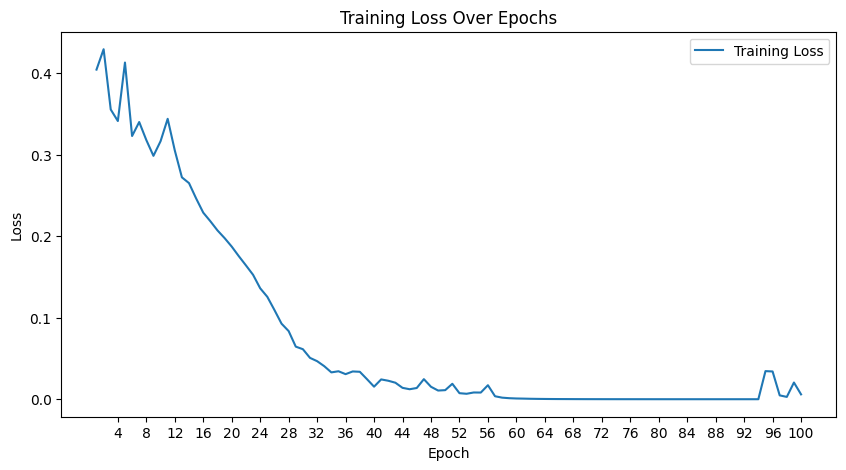

In [103]:
# 绘制训练过程中的损失曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 设置横坐标的刻度为
num_epochs = len(loss_history)
xticks = range(4, num_epochs + 1, 4)  # 从 2 开始，每隔 2 个 epoch 设置一个刻度
plt.xticks(xticks)

plt.show()

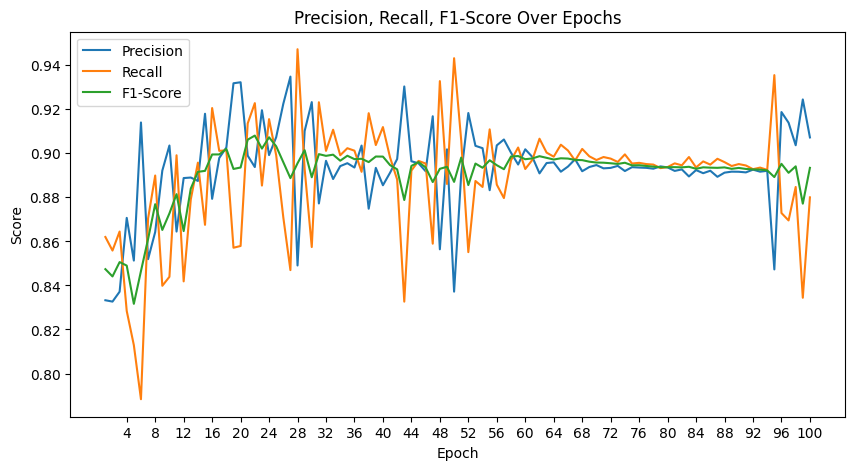

In [104]:
# 绘制 Precision, Recall, F1-Score 的变动曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(precision_history) + 1), precision_history, label='Precision')
plt.plot(range(1, len(recall_history) + 1), recall_history, label='Recall')
plt.plot(range(1, len(f1_history) + 1), f1_history, label='F1-Score')
plt.title('Precision, Recall, F1-Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# 设置横坐标的刻度为
num_epochs = len(precision_history)
xticks = range(4, num_epochs + 1, 4)  # 从 2 开始，每隔 2 个 epoch 设置一个刻度
plt.xticks(xticks)

plt.show()

### 8. 特殊案例分析

In [116]:
net = torch.load("./model/lstm_final.model")    # 训练所得最后模型

/tmp/ipykernel_29296/3723413494.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load("./model/lstm_final.model")    # 训练所得最后模型


In [ ]:
#封装函数，用于预测新的文本
def predict_sentiment(strs):
    data = []
    for s in strs:
        vectors = []
        for w in processing(s).split(" "):
            if w in word2vec.wv.key_to_index:
                vectors.append(word2vec.wv[w])   # 将每个词替换为对应的词向量
        vectors = torch.Tensor(vectors) # 转换为张量
        data.append(vectors) # 添加到数据集中
    x, _, lengths = collate_fn(list(zip(data, [-1] * len(strs)))) # 用collate_fn处理数据
    with torch.no_grad():
        x = x.to(device) # 将数据移动到 GPU/CPU
        outputs = lstm(x, lengths)          # 前向传播
        outputs = outputs.view(-1)          # 将输出展平
    return outputs # 返回预测结果

以下测试案例由Deepseek Chat生成
- **模棱两可的评论**：

In [118]:
predict_sentiment(["The movie had its moments, but overall, it left me feeling indifferent."])

tensor([0.0156], device='cuda:0')

- **正面和负面情感混合的评论**：

In [119]:
predict_sentiment(["The acting was superb, but the plot was a bit predictable."])

tensor([0.0024], device='cuda:0')

In [120]:
predict_sentiment(["The soundtrack was amazing, but the pacing was painfully slow."])

tensor([0.0003], device='cuda:0')

In [121]:
predict_sentiment(["The cinematography was breathtaking, but the story was a bit underwhelming."])

tensor([0.1069], device='cuda:0')

- **中立但带有情感色彩的评论**：

In [122]:
predict_sentiment(["I can't say I loved it, but I also can't say I hated it."])

tensor([0.0083], device='cuda:0')

In [123]:
predict_sentiment(["It wasn't the worst movie I've ever seen, but it wasn't the best either."])

tensor([3.5420e-05], device='cuda:0')

- **复杂情感的评论**：

In [124]:
predict_sentiment(["The movie was visually stunning, but the dialogue felt forced at times."])

tensor([0.9999], device='cuda:0')

In [125]:
predict_sentiment(["The movie had some great moments, but it also had some really disappointing ones."])

tensor([3.3073e-06], device='cuda:0')

- **带有讽刺意味的评论**：

In [126]:
predict_sentiment(["A masterpiece of mediocrity."])

tensor([0.9763], device='cuda:0')

In [127]:
predict_sentiment(["A film that manages to be both boring and exciting at the same time."])

tensor([0.0001], device='cuda:0')